# 3rd Level Model Structure: Single Stage Reactive Distillation

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

In [2]:
from pyomo import environ as pe
from modules.global_set import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF
from utility.data_utility import cal_cnumber

model = pe.ConcreteModel()

# Global Set

In [3]:
model.TRAY = pe.RangeSet(1,3)

# Construct Reactive Stages

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].T_F
| reactive[1].P
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].T
| reactive[1].H_F
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_block.r_WGS
| reactive[1].kinetics_bloc

# Construct a single condenser

In [5]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| condenser.VLE_blo

# Linking Stage Variables

### Vapor Between Reactive Stages

In [6]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [7]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Condenser

In [8]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

In [9]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

In [10]:
model.obj = pe.Objective(expr = sum(model.reactive[j].T for j in model.TRAY) ,sense=pe.maximize)

# Load from single stage solutions

In [11]:
with open('../saved_solutions/1_stage_condenser_adiabatic.pickle', 'rb') as f:
    results_imported = pickle.load(f)
results_changed = results_imported

### Duplicate variable solution and bounds multiplier

In [12]:
for i in list(results_imported.Solution.Variable.keys()):
    if i.startswith('reactive[1].'):
        for j in model.TRAY:
            if j != 1:
                results_changed.Solution.Variable[i.replace('reactive[1].','reactive[{}].'.format(j))] = \
                results_imported.Solution.Variable[i]

### Duplicate constraint multiplier

In [13]:
for i in list(results_changed.Solution.Constraint.keys()):
    if i.startswith('reactive[1].'):
        for j in model.TRAY:
            if j != 1:
                results_changed.Solution.Constraint[i.replace('reactive[1].','reactive[{}].'.format(j))] = \
                results_imported.Solution.Constraint[i]

### Load changed solution into current model

In [14]:
model.solutions.load_from(results_changed)

# Fixing Redundent Stream Variables

In [15]:
# condenser
model.condenser.VLE_block.n_ave.fix(4)

model.condenser.F.fix(0)
model.condenser.T_F.fix(300+273.15)
model.condenser.z.fix(0)

model.condenser.V['P'].fix(0)
model.condenser.L['in'].fix(0)
for i in m.COMP_TOTAL: model.condenser.x_['in',i].fix(0)
model.condenser.H_L_['in'].fix(0)

In [16]:
# 'reboiler' fixing last stage V_in

model.reactive[model.TRAY.last()].V['in'].fix(0)
for i in m.COMP_TOTAL: model.reactive[model.TRAY.last()].y_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)

# Load Operating Parameters

In [17]:
# condenser
model.condenser.P.fix(19)
# model.condenser.T.fix(30+273.15)
model.condenser.T.fix(30+273.15)
model.condenser.L['out'].fix(0)

# reactive stage
for j in model.reactive:
    model.reactive[j].cat.fix(5000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(20)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(1/(1+2))
    model.reactive[j].z['H2'].fix(2/(1+2))
    model.reactive[j].z['C30H62'].fix(0)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    # model.reactive[j].Q_main.fix(0)
    model.reactive[j].T.setub(250+273.15)

In [18]:
check_DOF(pe,model)

Active Equality Constraints:	 4986
Active Inequality Constraints:	 0
Active Variables:		 5191
Fixed Variables:		 202
DOF:				 3


In [19]:
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['constr_viol_tol'] = 1e-7
# opt.options['acceptable_constr_viol_tol'] = 1e-7
opt.options['max_iter'] = 7000
# opt.options['dual_inf_tol'] = '+inf'
# opt.options['acceptable_dual_inf_tol'] = '+inf'

In [20]:
add_dual(pe,model)
update_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [21]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    16286
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

  76r-1.5692389e+03 3.55e+01 9.99e+02   0.7 0.00e+00    -  0.00e+00 3.39e-07R  5
  77r-1.5692391e+03 3.55e+01 9.97e+02   0.7 4.33e+03    -  1.72e-02 9.89e-06f  1
  78r-1.5693743e+03 3.10e+00 9.82e+02   0.7 1.79e+03    -  2.06e-02 1.35e-02f  1
  79 -1.5693723e+03 3.10e+00 1.98e+03  -1.0 5.42e+03    -  1.45e-05 4.81e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.5693719e+03 3.10e+00 1.34e+03  -1.0 5.64e+03    -  7.98e-04 1.46e-05h  1
  81 -1.5692365e+03 3.10e+00 4.80e+02  -1.0 3.41e+04    -  2.84e-04 7.14e-04h  1
  82 -1.5689429e+03 3.10e+00 1.64e+03  -1.0 3.89e+04    -  9.39e-04 1.21e-03h  1
  83r-1.5689429e+03 3.10e+00 9.99e+02   0.0 0.00e+00    -  0.00e+00 4.64e-07R  4
  84r-1.5689453e+03 3.03e+00 9.99e+02   0.0 7.11e+03    -  1.14e-02 5.44e-05f  1
  85r-1.5692314e+03 1.84e+00 9.86e+02   0.0 3.56e+03    -  1.01e-02 1.30e-02f  1
  86r-1.5694026e+03 2.54e+00 9.72e+02   0.0 1.94e+03    -  1.71e-02 1.44e-02f  1
  87r-1.5694402e+03 2.62e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -1.5682047e+03 5.75e-02 1.59e+08  -1.0 5.75e+01    -  4.67e-02 3.15e-01h  1
 171 -1.5674174e+03 1.80e-01 2.32e+07  -1.0 1.16e+02    -  1.55e-01 9.04e-01h  1
 172 -1.5674708e+03 1.58e-03 2.05e+20  -1.0 1.58e+01  13.4 9.90e-01 9.92e-01h  1
 173r-1.5674708e+03 1.58e-03 1.00e+03  -1.0 0.00e+00  19.2 0.00e+00 0.00e+00R  1
 174r-1.5674711e+03 1.57e-03 1.86e+04  -1.0 5.16e+01    -  9.62e-02 8.16e-04f  1
 175r-1.5674765e+03 1.49e-03 1.73e+04  -1.0 5.30e+01    -  2.01e-02 1.13e-02f  1
 176r-1.5674887e+03 5.23e-03 1.67e+04  -1.0 5.28e+01    -  3.14e-02 2.57e-02f  1
 177 -1.5675022e+03 8.20e-04 9.06e+04  -1.0 2.55e+01    -  9.88e-01 9.90e-01H  1
 178 -1.5678040e+03 7.23e-03 6.61e+06  -1.0 4.04e+02    -  4.39e-01 5.15e-02f  3
 179 -1.5678813e+03 7.77e-03 1.56e+07  -1.0 4.27e+02    -  9.73e-01 1.47e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -1.5679030e+03 7.73e-03

In [22]:
update_dual(pe,model)

In [23]:
beautify2(pe,model)

Here comes the result:
----------------------------------------------------------------------------------------------------
		T		 Q			 V			 L
               30.00 	       -53.6216142959 	         0.3670491333 	         0.0000000000
              250.00 	       -46.2993624923 	         1.2961856729 	         0.0000009725
              250.00 	       -46.2993624923 	         0.8641237819 	         0.0000019449
              250.00 	       -46.2993624923 	         0.4320618910 	         0.0000029174
----------------------------------------------------------------------------------------------------
Top
V	 0.36704913331042266
L	 0.10504638806722655
W	 0.8240901515425827
----------------------------------------------------------------------------------------------------
Bottom
L	 2.917378298819824e-06
----------------------------------------------------------------------------------------------------
Condenser:	Vapor		Liquid		Last Stage	Vapor		Liquid
H2 		38.422%		0.506%		 H2       	10.921%

In [24]:
model.reactive[1].kinetics_block.r_FT_total.value

0.30381440327949927

In [25]:
# model.solutions.store_to(results)
# with open('../saved_solutions/3_stage_condenser_240C.pickle','wb') as f:
#     pickle.dump(results,f)

# So, what exactly does adding a reflux do?

In [26]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [27]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [28]:
Refluxrange = np.linspace(0,2,21)
Trange = np.linspace(250+273.15,200+273.15,11)

In [29]:
cd_data_master = {}
rf_data_master = {}

for t in Trange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = sum(model.reactive[j].T for j in model.TRAY) ,sense=pe.maximize)
    model.solutions.load_from(results_anchor)
    update_dual(pe,model)
    
    for j in model.reactive:
        model.reactive[j].T.fixed = False
        model.reactive[j].T.setub(t)
    model.condenser.L['out'].fix(0)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.condenser.L['out'],sense=pe.maximize)
    model.condenser.L['out'].fixed = False
    for j in model.reactive:
        model.reactive[j].T.fixed=True
    
    print('\nWorking on T = {} K'.format(model.reactive[1].T.value))
    print('-'*108)
    
    cd_data = {};
    cd_data['Re'] = []; cd_data['D'] = []; cd_data['V'] = []
    cd_data['x'] = {}; cd_data['y'] = {}; cd_data['g'] = {}; cd_data['d'] = {};
    for i in m.COMP_TOTAL:
        cd_data['x'][i] = []
        cd_data['y'][i] = []
        cd_data['g'][i] = []
        cd_data['d'][i] = []

    rf_data = {}
    for j in model.reactive:
        rf_data[j] = {}
        rf_data[j]['r'] = {}; rf_data[j]['b'] = {}; rf_data[j]['x'] = {};rf_data[j]['y'] = {};
        rf_data[j]['T'] = []; rf_data[j]['Q'] = []; rf_data[j]['V'] = []; rf_data[j]['L'] = []; 
        rf_data[j]['r_WGS'] = []; rf_data[j]['r_FT'] = []
        for i in m.COMP_TOTAL:
            rf_data[j]['r'][i] = []
            rf_data[j]['b'][i] = []
            rf_data[j]['x'][i] = []
            rf_data[j]['y'][i] = []       

    for re in Refluxrange:
        model.condenser.L['out'].setub(re)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        print('Solved\t|Reflux = {:.3f} kmol/s\t|Vapor = {:.3f} kmol/s\t|Distillate = {:.3f} kmol/s\t|Bottom = {:.3f} kmol/s'.\
              format(model.condenser.L['out'].value,model.condenser.V['out'].value,model.condenser.L['P'].value,model.reactive[3].L['out'].value))

        cd_data['V'].append(model.condenser.V['out'].value)
        cd_data['D'].append(model.condenser.L['P'].value)
        cd_data['Re'].append(model.condenser.L['out'].value)

        for i in model.reactive[1].r_total_comp:
            cd_data['x'][i].append(model.condenser.x[i].value)
            cd_data['y'][i].append(model.condenser.y[i].value)
            cd_data['g'][i].append(model.condenser.y[i].value*model.condenser.V['out'].value)
            cd_data['d'][i].append(model.condenser.x[i].value*model.condenser.L['P'].value)

        for j in model.reactive:      
            rf_data[j]['T'].append(model.reactive[j].T.value)
            rf_data[j]['Q'].append(model.reactive[j].Q_main.value)
            rf_data[j]['V'].append(model.reactive[j].V['out'].value)
            rf_data[j]['L'].append(model.reactive[j].L['out'].value)
            rf_data[j]['r_WGS'].append(model.reactive[j].kinetics_block.r_WGS.value)
            rf_data[j]['r_FT'].append(model.reactive[j].kinetics_block.r_FT_total.value)

            for i in model.reactive[1].r_total_comp:
                rf_data[j]['r'][i].append(model.reactive[j].r_total_comp[i].value)
                rf_data[j]['b'][i].append(model.reactive[j].x[i].value*model.reactive[j].L['out'].value)
                rf_data[j]['x'][i].append(model.reactive[j].x[i].value)
                rf_data[j]['y'][i].append(model.reactive[j].y[i].value)
        
    cd_data_master[t] = cd_data
    rf_data_master[t] = rf_data


Working on T = 523.15 K
------------------------------------------------------------------------------------------------------------
Solved	|Reflux = 0.000 kmol/s	|Vapor = 0.367 kmol/s	|Distillate = 0.105 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.100 kmol/s	|Vapor = 0.372 kmol/s	|Distillate = 0.104 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.200 kmol/s	|Vapor = 0.377 kmol/s	|Distillate = 0.103 kmol/s	|Bottom = 0.001 kmol/s
Solved	|Reflux = 0.300 kmol/s	|Vapor = 0.382 kmol/s	|Distillate = 0.102 kmol/s	|Bottom = 0.001 kmol/s
Solved	|Reflux = 0.400 kmol/s	|Vapor = 0.386 kmol/s	|Distillate = 0.100 kmol/s	|Bottom = 0.002 kmol/s
Solved	|Reflux = 0.500 kmol/s	|Vapor = 0.391 kmol/s	|Distillate = 0.099 kmol/s	|Bottom = 0.003 kmol/s
Solved	|Reflux = 0.600 kmol/s	|Vapor = 0.395 kmol/s	|Distillate = 0.097 kmol/s	|Bottom = 0.004 kmol/s
Solved	|Reflux = 0.700 kmol/s	|Vapor = 0.400 kmol/s	|Distillate = 0.096 kmol/s	|Bottom = 0.005 kmol/s
Solved	|Reflux = 0.800 kmol/s	|Vapor = 0.404 kmol/

Solved	|Reflux = 1.300 kmol/s	|Vapor = 0.482 kmol/s	|Distillate = 0.051 kmol/s	|Bottom = 0.033 kmol/s
Solved	|Reflux = 1.400 kmol/s	|Vapor = 0.487 kmol/s	|Distillate = 0.050 kmol/s	|Bottom = 0.034 kmol/s
Solved	|Reflux = 1.500 kmol/s	|Vapor = 0.491 kmol/s	|Distillate = 0.049 kmol/s	|Bottom = 0.034 kmol/s
Solved	|Reflux = 1.600 kmol/s	|Vapor = 0.496 kmol/s	|Distillate = 0.048 kmol/s	|Bottom = 0.035 kmol/s
Solved	|Reflux = 1.700 kmol/s	|Vapor = 0.500 kmol/s	|Distillate = 0.047 kmol/s	|Bottom = 0.036 kmol/s
Solved	|Reflux = 1.800 kmol/s	|Vapor = 0.504 kmol/s	|Distillate = 0.046 kmol/s	|Bottom = 0.036 kmol/s
Solved	|Reflux = 1.900 kmol/s	|Vapor = 0.508 kmol/s	|Distillate = 0.045 kmol/s	|Bottom = 0.037 kmol/s
Solved	|Reflux = 2.000 kmol/s	|Vapor = 0.512 kmol/s	|Distillate = 0.044 kmol/s	|Bottom = 0.037 kmol/s

Working on T = 503.15 K
------------------------------------------------------------------------------------------------------------
Solved	|Reflux = 0.000 kmol/s	|Vapor = 0.432 kmol/

Solved	|Reflux = 0.500 kmol/s	|Vapor = 0.601 kmol/s	|Distillate = 0.016 kmol/s	|Bottom = 0.044 kmol/s
Solved	|Reflux = 0.600 kmol/s	|Vapor = 0.610 kmol/s	|Distillate = 0.014 kmol/s	|Bottom = 0.045 kmol/s
Solved	|Reflux = 0.700 kmol/s	|Vapor = 0.619 kmol/s	|Distillate = 0.012 kmol/s	|Bottom = 0.046 kmol/s
Solved	|Reflux = 0.800 kmol/s	|Vapor = 0.627 kmol/s	|Distillate = 0.011 kmol/s	|Bottom = 0.047 kmol/s
Solved	|Reflux = 0.900 kmol/s	|Vapor = 0.635 kmol/s	|Distillate = 0.009 kmol/s	|Bottom = 0.048 kmol/s
Solved	|Reflux = 1.000 kmol/s	|Vapor = 0.643 kmol/s	|Distillate = 0.008 kmol/s	|Bottom = 0.049 kmol/s
Solved	|Reflux = 1.100 kmol/s	|Vapor = 0.651 kmol/s	|Distillate = 0.006 kmol/s	|Bottom = 0.050 kmol/s
Solved	|Reflux = 1.200 kmol/s	|Vapor = 0.659 kmol/s	|Distillate = 0.005 kmol/s	|Bottom = 0.051 kmol/s
Solved	|Reflux = 1.300 kmol/s	|Vapor = 0.666 kmol/s	|Distillate = 0.004 kmol/s	|Bottom = 0.051 kmol/s
Solved	|Reflux = 1.400 kmol/s	|Vapor = 0.673 kmol/s	|Distillate = 0.003 kmol/s	|Bo

Solved	|Reflux = 0.467 kmol/s	|Vapor = 0.857 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.039 kmol/s
Solved	|Reflux = 0.467 kmol/s	|Vapor = 0.857 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.039 kmol/s


In [30]:
cnumber_range = range(1,57)

In [31]:
def trans_cnumber(dic):
    molefraction = {}
    for i in range(1,57):
        molefraction[i] = []
    for i in m.COMP_ORG:
        molefraction[cal_cnumber(i)].append(np.array(dic[i]))
    for i in range(1,57):
        molefraction[i] = np.sum(molefraction[i],0)
    length = len(molefraction[1])
    tmp = {}
    for j in range(length):
        tmp[j] = []
        for i in range(1,57):
            tmp[j].append(molefraction[i][j])
    return tmp

In [32]:
g_data = {}
d_data = {}
b_data = {}
cd_x_data = {}
rf_x_data = {}

for t in Trange:

    g_data[t] = trans_cnumber(cd_data_master[t]['g'])
    d_data[t] = trans_cnumber(cd_data_master[t]['d'])
    b_data[t] = trans_cnumber(rf_data_master[t][3]['b'])

    cd_x_data[t] = trans_cnumber(cd_data_master[t]['x'])
    rf_x_data[t] = {}
    for j in model.reactive:
        rf_x_data[t][j] = trans_cnumber(rf_data_master[t][j]['x'])

In [33]:
 def plot_distribution(index,temperature):
    fig, (ax,ax2) = plt.subplots(2,1,figsize=(16,12))
    ax.plot(cnumber_range,g_data[temperature][index],'co-')
    ax.plot(cnumber_range,d_data[temperature][index],'go-')
    ax.plot(cnumber_range,b_data[temperature][index],'ro-')
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1)
    ax.legend(['Vapor','Distillate','Bottom'],fontsize=18)
    ax.set_title('T, Reflux {:.2f} kmol/s'.format(cd_data_master[temperature]['Re'][index]),fontsize=18)

    ax.set_ylabel('Molar Flow (kmol/s)', color='K',fontsize=18)
    ax.set_xlabel('Carbon Number', color='K',fontsize=18)
    # ax.tick_params('y', colors='k',labelsize=18)
    # ax.tick_params('x', colors='k',labelsize=18)

    ax2.plot(cnumber_range,cd_x_data[temperature][index],'go-')
    ax2.plot(cnumber_range,rf_x_data[temperature][1][index],'co-')
    ax2.plot(cnumber_range,rf_x_data[temperature][2][index],'bo-')
    ax2.plot(cnumber_range,rf_x_data[temperature][3][index],'ro-')

    ax2.set_ylim(0, 0.2)
    ax2.legend(['Condenser','Stage 1','Stage 2','Stage 3'],fontsize=18)
    ax2.set_title('Liquid Composition (Mole)',fontsize=18)

    ax2.set_ylabel('Molar Fraction', color='K',fontsize=18)
    ax2.set_xlabel('Carbon Number', color='K',fontsize=18)

    ax.grid()
    ax2.grid()
    plt.show()

In [34]:
widgets.interact(plot_distribution, index = widgets.IntSlider(
    value=0,
    min=0,
    max=20,
    step=1,
    description='Reflux:'),temperature=widgets.SelectionSlider(
    options=Trange,
    value=Trange[0],
    description='Temperature',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True)
);

interactive(children=(IntSlider(value=0, description='Reflux:', max=20), SelectionSlider(continuous_update=Fal…

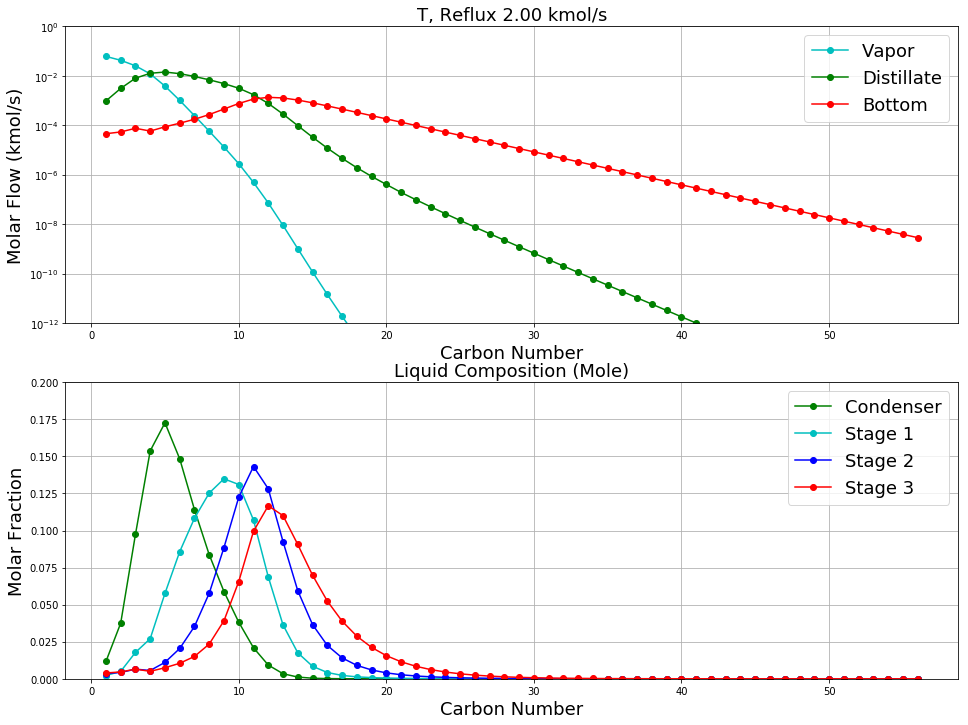

In [36]:
plot_distribution(20,523.15)